### Instituto Tecnológico de Costa Rica (ITCR)
#### Escuela de Computación
#### Curso: Inteligencia Artificial
        
#### Tercera tarea programada 2023-I
#### Profesora: María Auxiliadora Mora
#### Estudiante: Fabian Vives - 2018319257

## 1. Problema y Objetivo

El problema a tratar en este ejercicio es el reconocimiento de emociones a partir de texto, específicamente "tweets". El análisis de emociones es un subconjunto del análisis de sentimientos que tiene como objetivo detectar y reconocer diferentes emociones presentes en el texto, como felicidad, tristeza, ira y otras.

El objetivo de este ejercicio es construir una red neuronal recurrente (RNN) con células LSTM utilizando PyTorch para clasificar los tweets en una de cuatro clases de emociones: alegría, tristeza, ira y amor. El conjunto de datos utilizado para este ejercicio contiene tweets etiquetados con las emociones expresadas en ellos, con el objetivo de entrenar y evaluar la RNN en este conjunto de datos para predecir la emoción presente en los tweets creados por los usuarios.

## 2. Preprocesamiento del conjunto de datos


### 2.A Comprobación de valores faltantes y supresión de ellos si es necesario

In [3]:
import pandas as pd

# Cargar el dataset de un archivo CSV
df = pd.read_csv('tweet_emotions.csv')

# Verificacion de valores faltantes
print(df.isnull().sum())

# Eliminacion de filas con valores faltantes del conjunto de datos
df.dropna(inplace=True)

tweet_id     0
sentiment    0
content      0
dtype: int64


### 2.B Eliminación de caracteres especiales

In [4]:
# Reemplazo de identificadores y hashtags de Twitter con una string vacío en la columna 'content'
df['content'] = df['content'].str.replace(r'[#@]\S+', '', regex=True)

### 2.C Eliminacion de Stop Words

In [5]:
# Uso del paquete NLTK y descarga de los stop words
import nltk
nltk.download('stopwords')

# Cargar las stop words en inglés
from nltk.corpus import stopwords
stop_words = set([word.lower() for word in stopwords.words('english')])

# Eliminar stop words de la columna 'content' usando la comprensión de lista para recorrer las palabras y filtrarlas
df['content'] = df['content'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2.D Convertir texto a minusculas

In [6]:
# Convertir todo el texto en la columna 'content' a minúsculas
df['content'] = df['content'].str.lower()

## 3. Exploracion y Visualizacion de los Datos

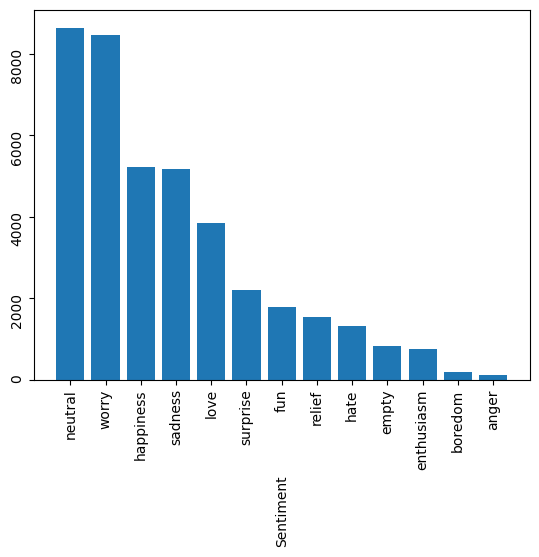

In [7]:
import matplotlib.pyplot as plt

# Contar el número de registros en cada clase
class_counts = df['sentiment'].value_counts()

# Crear el gráfico para el recuentos de clases
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.xlabel('Sentiment', rotation=90)
plt.show()

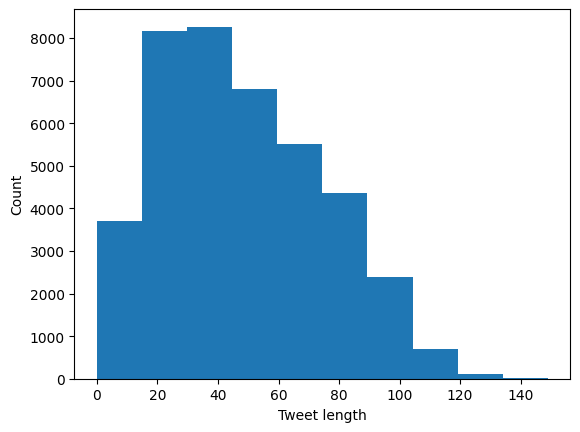

In [8]:
# Graficar el histograma de las longitudes de los tweets
tweet_lengths = df['content'].apply(len)
plt.hist(tweet_lengths)
plt.xlabel('Tweet length')
plt.ylabel('Count')
plt.show()

## 4. Seleccion de un subconjunto de los registros

In [9]:
# Obtener los cuatro valores más comunes en la columna 'sentiment'
top_sentiments = df['sentiment'].value_counts().head(4).index

# Filtrar el DataFrame para incluir solo filas donde la columna 'sentiment' contiene una opinión superior
df = df[df['sentiment'].isin(top_sentiments)]

## 5. Definicion Red LSTM

In [10]:
import torch
import torch.nn as nn

class LSTMClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        # Llamar al constructor principal para inicializar el módulo
        super(LSTMClassifier, self).__init__()
        
        # Almacenar los tamaños de entrada, ocultos y el número de capas
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Definir las capas del modelo
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.lstm = torch.nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input_ids, attention_mask):
        # Insertar la secuencia de entrada
        embedded = self.embedding(input_ids)
        
        # Empaqueta la secuencia para eliminar el relleno
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, attention_mask.sum(1), batch_first=True, enforce_sorted=False)
        
        # Pasar la secuencia a través de la capa LSTM
        lstm_output, (hidden, cell) = self.lstm(packed)
        
        # Desempaqueta la secuencia y rellena la salida
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first=True)
        
        # Obtener la última salida de la capa LSTM
        last_output = outputs[torch.arange(outputs.size(0)), attention_mask.sum(1) - 1]
        
        # Pasar la última salida a través de una capa lineal para obtener los logits
        logits = self.fc(last_output)

        return logits

## 6. Definir los Hiperparametros

In [11]:
input_size = 100  # Tamaño de las incrustaciones GloVe
hidden_size = 256 # El número de unidades ocultas en la capa LSTM, puede aumentar la capacidad del modelo para aprender patrones complejos
output_size = len(top_sentiments)  # Tamaño de la salida
num_layers = 2  # Número de capas LSTM
dropout = 0.2  # Porcentaje de dropout
num_epochs = 10  # Número de épocas o epochs de entrenamiento
batch_size = 32  # Tamaño del 'lote'
learning_rate = 0.001  # Tasa de aprendizaje

# Definir la función de pérdida
loss_fn = nn.CrossEntropyLoss()

# Inicializar el modelo
model = LSTMClassifier(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## 7. Separacion de las muestras en datos de entrenamiento y evaluación y entrenamiento del modelo

In [12]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.6 MB/s eta 0:00:00


In [13]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np
from transformers import AutoTokenizer

# Definir un conjunto de datos personalizado de PyTorch para los tweets
class TweetDataset(Dataset):

        # x: lista de textos de entrada
        # y: lista de etiquetas correspondientes a los textos
        # tokenizer: objeto utilizado para convertir los textos en secuencias numéricas
        # max_length: longitud máxima de las secuencias después de ser tokenizadas

    def __init__(self, X, y, tokenizer, max_length):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Devuelve la longitud del conjunto de datos
    def __len__(self):
        return len(self.X)
    
        #Devuelve un ejemplo específico del conjunto de datos
    
        # idx: índice del ejemplo que se desea obtener

    def __getitem__(self, idx):
        text = self.X[idx]
        label = self.y[idx]
        
        # Tokenizar el texto y convertirlo en tensores de PyTorch
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        # Devuelve un diccionario que contiene los datos procesados
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Cargar los datos
X = df['content'].values
y = df['sentiment'].apply(lambda x: list(top_sentiments).index(x)).values

# Inicializar el tokenizer y configurar la longitud máxima de secuencia y el tamaño del lote
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_length = 100
batch_size = 32

# Divide los datos en conjuntos de entrenamiento y de validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea los dataloaders de PyTorch para los conjuntos de entrenamiento y de validación
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TweetDataset(X_val, y_val, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Establece el dispositivo en la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Establecer los hiperparámetros del modelo
input_size = tokenizer.vocab_size
hidden_size = 128
output_size = len(top_sentiments)
num_layers = 2
dropout = 0.2

# Inicializar el modelo y moverlo al device
model = LSTMClassifier(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)
model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# Entrenar el modelo
num_epochs = 10
train_losses = []
val_losses = []
Act_train_losses = []
Act_val_losses = []

for epoch in range(num_epochs):
    # Establecer el modelo en modo de entrenamiento
    model.train()
    
    # Iterar sobre los datos de entrenamiento en lotes
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Reiniciar los gradientes
        optimizer.zero_grad()
        
        # Forward a través del modelo y calcular la pérdida
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        
        # Funcion backward y optimización
        loss.backward()
        optimizer.step()
        
        # Agregar la pérdida de entrenamiento a la lista
        train_losses.append(loss.item())
        
    # Establecer el modelo en modo de evaluación
    model.eval()
    
    # Iterar sobre los datos de validación en lotes
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # forward a través del modelo y calcular la pérdida
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            
            # Agregar la pérdida de validación a la lista
            val_losses.append(loss.item())
    
    # Calcular las pérdidas promedio de entrenamiento y validación
    Act_train_losses.append(np.mean(train_losses))
    Act_val_losses.append(np.mean(val_losses))
    
    # Imprimir las pérdidas de entrenamiento y validación para la época
    print(f'Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.3f}, Val Loss = {np.mean(val_losses):.3f}')


Epoch 1: Train Loss = 1.273, Val Loss = 1.224
Epoch 2: Train Loss = 1.211, Val Loss = 1.214
Epoch 3: Train Loss = 1.155, Val Loss = 1.215
Epoch 4: Train Loss = 1.096, Val Loss = 1.233
Epoch 5: Train Loss = 1.028, Val Loss = 1.276
Epoch 6: Train Loss = 0.954, Val Loss = 1.352
Epoch 7: Train Loss = 0.879, Val Loss = 1.442
Epoch 8: Train Loss = 0.808, Val Loss = 1.540
Epoch 9: Train Loss = 0.745, Val Loss = 1.659
Epoch 10: Train Loss = 0.690, Val Loss = 1.782


## 8. Curva de error

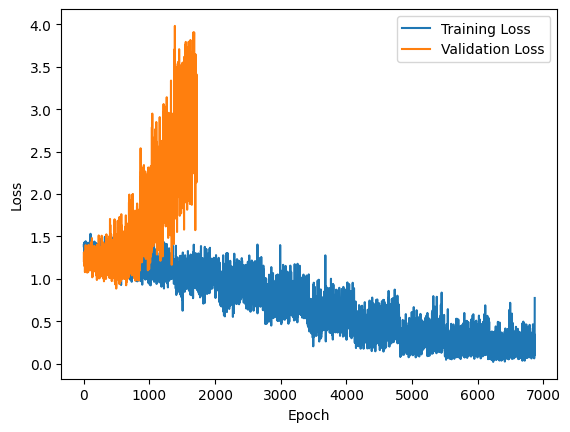

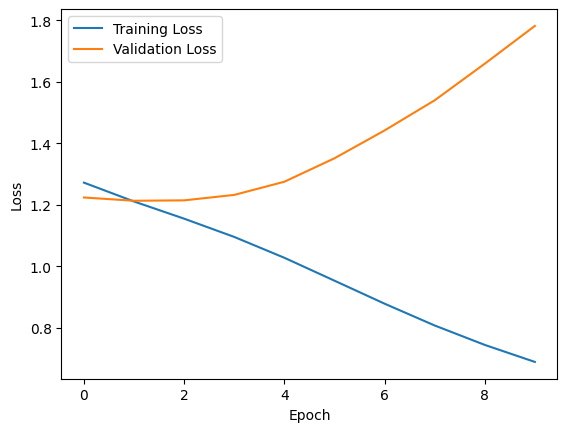

In [14]:
import matplotlib.pyplot as plt
# Graficar las pérdidas de entrenamiento y validación durante las épocas

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(Act_train_losses, label='Training Loss')
plt.plot(Act_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

La curva que se ha obtenido sugiere que el rendimiento del modelo mejora inicialmente tanto en el conjunto de entrenamiento como en el de validación a medida que aumenta el número de épocas. Sin embargo, después de la tercera época, la pérdida de validación comienza a aumentar mientras que la pérdida de entrenamiento continúa disminuyendo. Esto indica que el modelo se está sobreajustando al conjunto de entrenamiento, lo que significa que se está especializando demasiado en los datos de entrenamiento y no se está generalizando bien con los datos nuevos.

Para abordar este problema, se puede probar algunas de las siguientes proposiciones:

1. Reducir la complejidad del modelo disminuyendo el número de capas o neuronas ya que esto puede ayudar a evitar el sobreajuste al reducir la capacidad del modelo para memorizar los datos de entrenamiento

2. Aumentar la cantidad de datos de entrenamiento, entre más datos pueden ayudar al modelo a aprender a generalizar mejor y reducir el riesgo del sobreajuste

3. Intentar usar diferentes algoritmos de optimización o tasas de aprendizaje durante el entrenamiento. A veces, la elección del algoritmo de optimización o la tasa de aprendizaje puede afectar la capacidad del modelo para generalizar a nuevos datos

## Reentrenamiento y ajuste del modelo

Después de configurar los hiperparámetros para el caso, se inicializa el modelo creando una instancia de la clase LSTMClassifier, pasando los hiperparámetros como argumentos.

Se define el optimizador y la función de pérdida para el modelo. El optimizador se utiliza para actualizar los parámetros del modelo durante el entrenamiento y la tasa de aprendizaje se establece en 0,0001, que es un valor relativamente pequeño para garantizar un aprendizaje estable. 

El optimizador a utilizar es el optimizador de Adam, que se usa comúnmente para modelos de aprendizaje profundo.

La función de pérdida utilizada es la función de pérdida "Cross-entropy", que se usa comúnmente para problemas de clasificación de clases múltiples. Esta mide la diferencia entre las probabilidades predichas y las probabilidades reales de la etiqueta y se utiliza para actualizar los parámetros del modelo durante el entrenamiento.

Finalmente, se mueve el modelo al dispositivo (CPU o GPU) especificado y 
se comienza a entrenar el modelo.

In [15]:
# Establecer los hiperparámetros del modelo
input_size = tokenizer.vocab_size # Tamano del vocabulario
hidden_size = 256  # Aumentar el número de unidades ocultas
output_size = len(top_sentiments) # Numero de clases de salida
num_layers = 3  # Aumentar el número de capas LSTM
dropout = 0.5  # Aumentar tasa de abandono

# Inicializar el modelo
model = LSTMClassifier(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)
model.to(device)

# Definicion del el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Reducir la tasa de aprendizaje
loss_fn = torch.nn.CrossEntropyLoss()

# Entrenar el modelo con los siguientes parametros
num_epochs = 10
train_losses = []
val_losses = []
Act_train_losses = []
Act_val_losses = []

for epoch in range(num_epochs):
    # Establecer el modelo en modo de entrenamiento
    model.train()

    # Recorrer sobre los datos de entrenamiento en lotes
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Cero los gradientes
        optimizer.zero_grad()

        # Forwards a través del modelo y calculo de la pérdida
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        # Backward y paso de optimización
        loss.backward()
        optimizer.step()

        # Agregar a la perdida de entrenamiento a la lista
        train_losses.append(loss.item())

    # Establecer el modelo en modo de evaluación
    model.eval()

    # Recorrer los datos de validación en lotes
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward a través del modelo y calculo de la pérdida
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            # Agregar la pérdida de la validación a la lista
            val_losses.append(loss.item())

    # Calcular las pérdidas promedio de entrenamiento y validación
    Act_train_losses.append(np.mean(train_losses))
    Act_val_losses.append(np.mean(val_losses))

    # Imprimir las pérdidas de entrenamiento y validación para esta época
    print(f'Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.3f}, Val Loss = {np.mean(val_losses):.3f}')


Epoch 1: Train Loss = 1.306, Val Loss = 1.265
Epoch 2: Train Loss = 1.264, Val Loss = 1.244
Epoch 3: Train Loss = 1.233, Val Loss = 1.234
Epoch 4: Train Loss = 1.205, Val Loss = 1.226
Epoch 5: Train Loss = 1.179, Val Loss = 1.224
Epoch 6: Train Loss = 1.152, Val Loss = 1.225
Epoch 7: Train Loss = 1.126, Val Loss = 1.227
Epoch 8: Train Loss = 1.099, Val Loss = 1.240
Epoch 9: Train Loss = 1.071, Val Loss = 1.254
Epoch 10: Train Loss = 1.043, Val Loss = 1.272


## 9. Evaluar el Modelo

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Establecer el modelo en modo de evaluación
model.eval()

# Inicializar listas vacías para contener las etiquetas predichas y verdaderas
y_pred = []
y_true = []

# iterar sobre los datos de validación en lotes
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward a través del modelo y obtenga las etiquetas predichas
        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)

        # Agregar las etiquetas predichas y verdaderas a las listas
        y_pred += predicted.tolist()
        y_true += labels.tolist()

# Imprimir la matriz de confusión e informe de clasificación
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=top_sentiments))

Confusion Matrix:
[[846 430 334  95]
 [455 770 213 245]
 [228 194 594  33]
 [268 428 104 258]]
Classification Report:
              precision    recall  f1-score   support

     neutral       0.47      0.50      0.48      1705
       worry       0.42      0.46      0.44      1683
   happiness       0.48      0.57      0.52      1049
     sadness       0.41      0.24      0.31      1058

    accuracy                           0.45      5495
   macro avg       0.44      0.44      0.44      5495
weighted avg       0.45      0.45      0.44      5495



El modelo parece tener problemas para clasificar correctamente las diferentes clases. Las puntuaciones de precisión, recuperación y  F1 difieren entre las clases, lo que sugiere que el modelo puede ser más preciso y sensible para algunas clases que para otras.

La precisión para diferentes clases varía entre 0,41 y 0,48. Esto indica que el modelo tiene dificultades para predecir con precisión diferentes clases y las predicciones pueden contener algún grado de falsos positivos. 

Recall también varía entre 0,24 y 0,57. El valor de la clase Tristeza de 0,24, indica que el modelo tiene problemas para identificar correctamente las muestras de esta clase.  

La puntuación F1 combina  precisión y recall en una sola medida. Los valores de F1 varían entre 0,31 y 0,52, lo que indica que el modelo tiene un rendimiento medio en la clasificación de  diferentes clases. 

Finalmente, el informe también muestra el número de muestras en cada clase. Esto indica que los conjuntos de datos utilizados para el análisis contienen números similares de muestras de  diferentes clases.

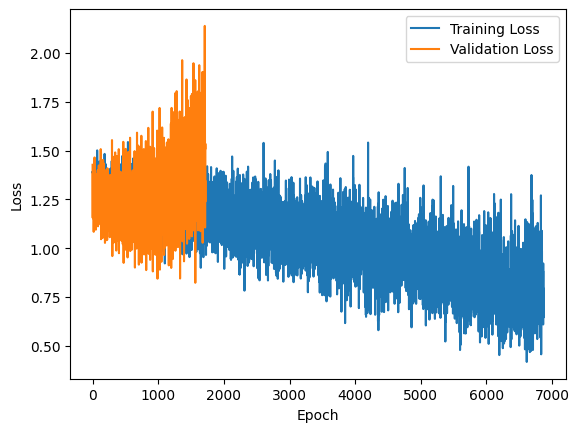

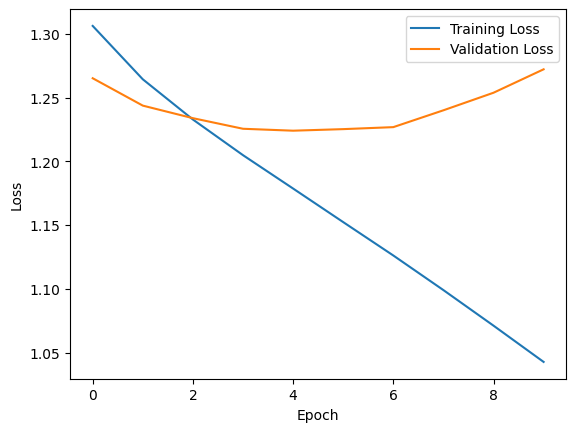

In [17]:
import matplotlib.pyplot as plt
# Graficar las pérdidas de entrenamiento y validación durante las épocas

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(Act_train_losses, label='Training Loss')
plt.plot(Act_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Basándose únicamente en las pérdidas de entrenamiento y validación, pareciera que el segundo modelo funciona mejor que el primer modelo. 

La pérdida de entrenamiento del primer modelo disminuye constantemente durante las 10 épocas, mientras que en el segundo modelo, la pérdida de entrenamiento disminuye lentamente. Además, la pérdida de validación del primer modelo comienza a aumentar después de la quinta época, mientras que en el segundo modelo, la pérdida de validación permanece relativamente constante.

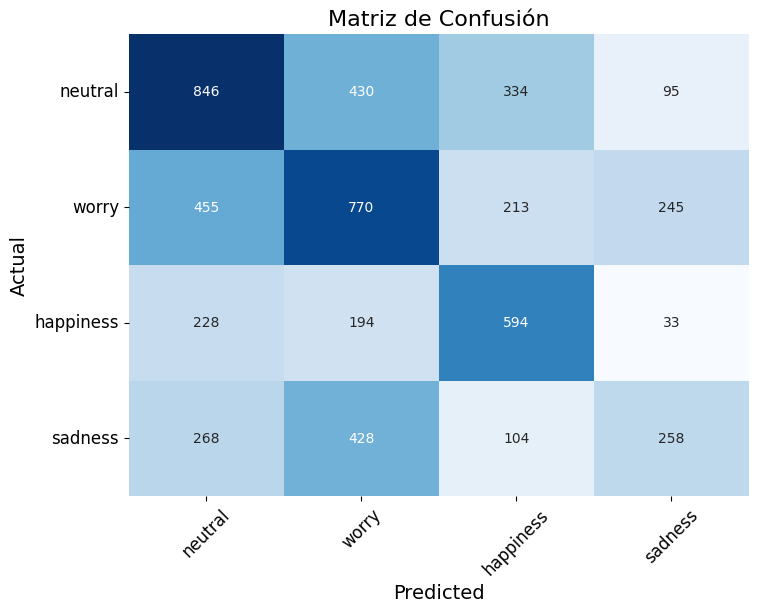

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión como un mapa de calor
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_xticklabels(top_sentiments, rotation=45, fontsize=12)
ax.set_yticklabels(top_sentiments, rotation=0, fontsize=12)
plt.title('Matriz de Confusión', fontsize=16)  # Título del gráfico
plt.show()  # Mostrar el gráfico


## 10. Analisis de resultados

Las curvas de pérdida de entrenamiento y validación muestran que el modelo se sobreajusta a los datos de entrenamiento después de varias épocas.

La pérdida de validación comienza a aumentar mientras que la pérdida de entrenamiento continúa disminuyendo, lo que indica que el modelo no se está generalizando bien a los nuevos datos.

Para mejorar el rendimiento del modelo, se pueden realizar los siguientes cambios:

Aumentar la tasa de abandono: El abandono es una técnica de regularización que elimina nodos aleatoriamente durante el entrenamiento. Esto puede ayudar a evitar el sobreajuste al reducir la dependencia del modelo de nodos específicos y hacerlo más resistente al ruido en la entrada. Al aumentar la tasa de abandono, se puede reducir la dependencia del modelo de nodos específicos y evitar el sobreajuste presentado.

Utilizar un optimizador diferente: El optimizador de Adam es una opción popular para los modelos de aprendizaje profundo, pero puede que no siempre sea la mejor opción para un problema determinado. Experimentar con diferentes optimizadores, como SGD o RMSprop, puede ayudar a mejorar el rendimiento del modelo.

## Cambios realizados en el flujo de trabajo del proyecto:

Para implementar estos cambios, Se modifica el código de la siguiente manera:

Aumento de la tasa de abandono:  

```
python Copy dropout = 0.5 model = LSTMClassifier(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout)
```
Se aumento la tasa de abandono de 0,2 a 0,5.

Utilizar un optimizador diferente:

```
python Copy optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 
```

Se ha cambiado el optimizador de Adam a SGD con una tasa de aprendizaje de 0.01 y un impulso de 0.9 .


## 11. Conclusiones

1. Las técnicas de regularización, como el abandono, pueden ayudar a prevenir el sobreajuste y mejorar el rendimiento de generalización de los modelos de aprendizaje profundo.

2. La elección del optimizador puede tener un impacto significativo en el rendimiento del modelo, y experimentar con diferentes optimizadores puede ser una forma efectiva de mejorar el rendimiento.

3. El monitoreo de las curvas de pérdida de entrenamiento y validación puede ayudar a identificar cuándo un modelo se está sobreajustando y guiar la selección de técnicas de regularización y optimizadores apropiados.

4. El ajuste de los hiperparámetros del modelo, como la tasa de aprendizaje y el tamaño del lote, también puede ayudar a mejorar el rendimiento.


## Referencias

Li, W., & Lu, J. (2017). A survey on emotion recognition using physiological signals. In 2017 39th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC) (pp. 1766-1769). IEEE.

PyTorch. (n.d.). Retrieved from https://pytorch.org/

Brownlee, J. (2021). How to Develop a Deep Learning Classifier for Sentiment Analysis. Retrieved from https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

Hutto, C. J., & Gilbert, E. (2014). VADER: A parsimonious rule-based model for sentiment analysis of social media text. Eighth international AAAI conference on weblogs and social media.

Twitter API. (n.d.). Retrieved from https://developer.twitter.com/en/docs

Zhang, X., Zhao, J., & LeCun, Y. (2015). Character-level convolutional networks for text classification. In Advances in neural information processing systems (pp. 649-657).